# Titanic survival

### Who will make it?


This notebook is prepared for training purpose.

We will explore the [Titanic survival data](https://www.kaggle.com/c/titanic) , and model the survival with decision trees.
(see [Decision Tree course](https://www.linkedin.com/learning/machine-learning-ai-foundations-decision-trees))

## 1. GOALS

 - predict survival rate of titanic passengers
 - practice decision trees
 - build a small data science project


## 2. Data understanding



In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


data = pd.read_csv("Titanic/train.csv")
print(data.info())
print("\n Embarked options: ", data["Embarked"].value_counts())

data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None

 Embarked options:  S    644
C    168
Q     77
Name: Embarked, dtype: int64


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Apply less memory-consuming data types to the data (see [Dataquest blog](https://www.dataquest.io/blog/pandas-big-data/))

In [2]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# setting up new data types
dtypes_col       = data.columns
dtypes_type_old  = data.dtypes
dtypes_type      = ['int16', 'bool','category','object','category','float32','int8','int8','object','float32','object','category']
optimized_dtypes = dict(zip(dtypes_col, dtypes_type))

#read data once again with optimized columns
data_optimized = pd.read_csv("Titanic/train.csv",dtype=optimized_dtypes)
test_optimized = pd.read_csv("Titanic/test.csv",dtype=optimized_dtypes)

combined = {"train":data_optimized,
            "test":test_optimized}

print(data_optimized.info())
data_optimized.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int16
Survived       891 non-null bool
Pclass         891 non-null category
Name           891 non-null object
Sex            891 non-null category
Age            714 non-null float32
SibSp          891 non-null int8
Parch          891 non-null int8
Ticket         891 non-null object
Fare           891 non-null float32
Cabin          204 non-null object
Embarked       889 non-null category
dtypes: bool(1), category(3), float32(2), int16(1), int8(2), object(3)
memory usage: 35.2+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250000,NaN,S
1,2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.283302,C85,C
2,3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925000,NaN,S
3,4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.099998,C123,S
4,5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050000,NaN,S


<span style="color:green"> Hooray! We saved more than half of the memory and the table is read properly!</span>

## Do we have any missing data?

In [4]:
data_optimized.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

"Cabin" column will not be interesting for us, because there is a lot of missing data.

"Age" column may be important for the model, and but some of decision tree models have a mechanism for estimating missing value based on correlation with other values if possible.


I will use [Kaggle, Anisotropic profile](https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial) to get the data analysis step by step.

In [5]:
for i,data in combined.items():
    data.drop('Cabin', 1,inplace=True)

data_optimized.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
dtype: int64

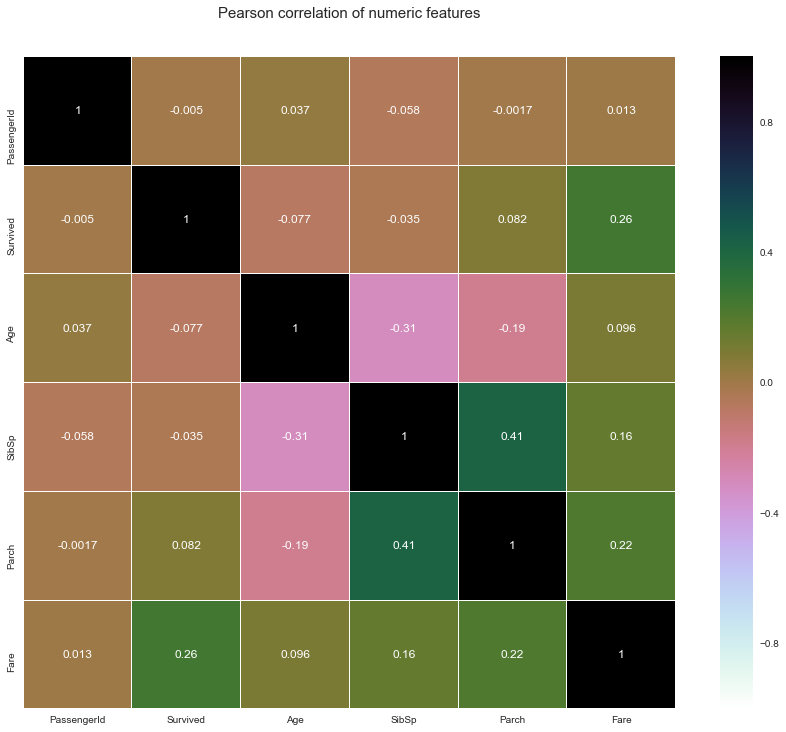

In [6]:
#numerical features

train_numeric = data_optimized.select_dtypes(include=['float32','int16','int8','bool'])

colormap = plt.cm.cubehelix_r
plt.figure(figsize=(16,12))

plt.title('Pearson correlation of numeric features', y=1.05, size=15)
sns.heatmap(train_numeric.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

Two interesting correlations are:
 - positive (0.41) for "SibSp" and "Parch"
 - negative  (-0.31) for "SibSp" and "Age"

[3, 1, 2]
Categories (3, object): [3, 1, 2]


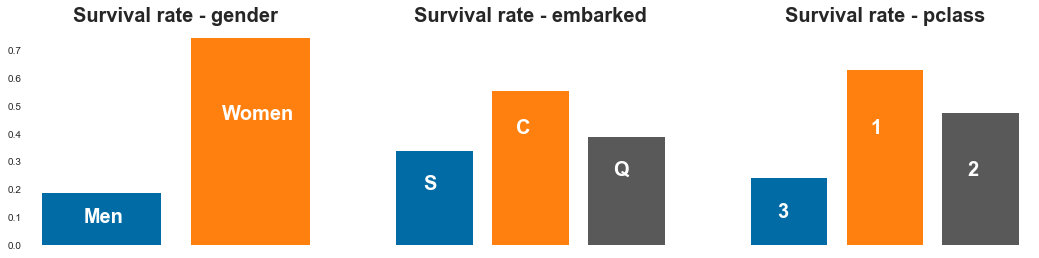

In [7]:
# category features

#we do not count NaN categories
def survived_percent(categories,column):
    survived_list = []
    for c in categories.dropna():
        count = data_optimized[data_optimized[column] == c][column].count()
        survived = data_optimized[data_optimized[column] == c]["Survived"].sum()/count
        survived_list.append(survived)
    return survived_list    
   
    
sexes = data_optimized["Sex"].unique()
sexes_survival = survived_percent(sexes,"Sex")

embarked = data_optimized["Embarked"].unique()
embarked_survival = survived_percent(embarked,"Embarked")

pclass = data_optimized["Pclass"].unique()
pclass.sort_values(inplace=True)
print (pclass)
pclass_survival = survived_percent(pclass,"Pclass")

fig, axs = plt.subplots(1, 3, figsize=(18, 4), sharey=True)
cb_dark_blue = (0/255,107/255,164/255)
cb_orange = (255/255, 128/255, 14/255)
cb_grey = (89/255, 89/255, 89/255)

font_dict = {'fontsize':20, 
             'fontweight':'bold',
             'color':"white"}

axs[0].bar([0,1], sexes_survival,color=[cb_dark_blue,cb_orange])
axs[1].bar(range(len(embarked_survival)),embarked_survival, color=[cb_dark_blue,cb_orange,cb_grey])
axs[2].bar(range(len(pclass_survival)),pclass_survival, color=[cb_dark_blue,cb_orange,cb_grey])

axs[0].text(-0.12, 0.08, "Men",**font_dict )
axs[0].text(0.81, 0.45, "Women",**font_dict )

axs[1].text(-0.12, 0.2,embarked[0] ,**font_dict  )
axs[1].text(0.85, 0.4,embarked[1] ,**font_dict )
axs[1].text(1.86, 0.25,embarked[2] ,**font_dict )


axs[2].text(-0.12, 0.1,pclass[0] , **font_dict)
axs[2].text(0.85, 0.4,pclass[1] ,**font_dict )
axs[2].text(1.86, 0.25,pclass[2] ,**font_dict )


axs[0].set_title("Survival rate - gender",fontsize=20, fontweight='bold' )
axs[1].set_title("Survival rate - embarked",fontsize=20, fontweight='bold' )
axs[2].set_title("Survival rate - pclass",fontsize=20, fontweight='bold' ) 

for figure in range(3):
    axs[figure].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off') # labels along the bottom edge are off
    axs[figure].patch.set_visible(False)


Gender is a key factor insurvival rate.

## 3. Filling missing data

For "Embarked" colum we will use most popular category which is "S", because there are only 2 records missing.

For "Age" column as a first attempt we will use age distribution $F_{Age}$ known from the rest of the data and generate random number from it. 

In [8]:
# filling NaN in "Embarked" and "Fare"

for i,data in combined.items():
    data["Embarked"].fillna(value="S",inplace=True) # S is most popular value 
    mean_Fare = data["Fare"].mean()
    data["Fare"].fillna(value=mean_Fare,inplace=True)

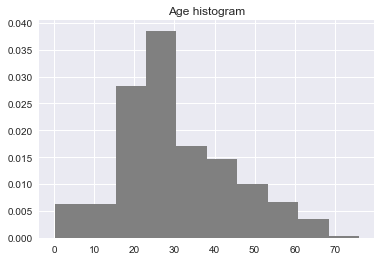

In [9]:
# filling NaN in "Age" 
fig, ax = plt.subplots( figsize=(6,4))
x = data["Age"].dropna()
hist, bins = np.histogram( x,bins=15)

#plot of histogram
ax.hist(x, normed=True, color='grey')
ax.set_title('Age histogram')
plt.show()


In [10]:
from random import choices

bin_centers = 0.5*(bins[:len(bins)-1]+bins[1:])
probabilities = hist/hist.sum()

#dictionary with random numbers from existing age distribution
rand_age = {}
for i,data in combined.items():
    rand_age[i] = {}
    for x in range(len(data["Age"].isnull())):
        rand_age[i][x] = np.random.choice(bin_centers, p=probabilities)

    #filling "Age" NaNs
    data["Age"].fillna(value=rand_age[i],inplace=True)


## 4. Modelling

### a) C&RT decision tree


column  Pclass  classes:  ['1' '2' '3']
column  Sex  classes:  ['female' 'male']
column  Embarked  classes:  ['C' 'Q' 'S']
column  Pclass  classes:  ['1' '2' '3']
column  Sex  classes:  ['female' 'male']
column  Embarked  classes:  ['C' 'Q' 'S']


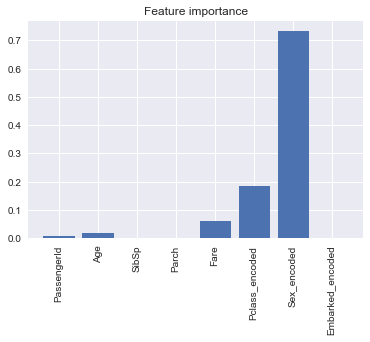

In [23]:
from sklearn import preprocessing,tree

tree_data = {}
tree_data_category = {}

for i,data in combined.items():
    tree_data[i] = data.select_dtypes(include=['float32','int16','int8']).copy()
    tree_data_category[i] = data.select_dtypes(include=['category'])

    #categorical variables handling
    for column in tree_data_category[i].columns:
        le = preprocessing.LabelEncoder()
        le.fit(data[column])
        print( "column ", column, " classes: ",le.classes_)
        tree_data[i][column+"_encoded"] = le.transform(data[column])

clf = tree.DecisionTreeClassifier(min_samples_leaf=20, max_depth=4,min_weight_fraction_leaf=0.1 )
X =  tree_data["train"]
Y = combined["train"]["Survived"]
clf.fit(X,Y)


train_columns = tree_data["train"].columns
fig, ax = plt.subplots( figsize=(6,4))
ax.bar(range(len(train_columns)),clf.feature_importances_ )
plt.xticks(range(len(train_columns)),train_columns,rotation=90)
ax.set_title("Feature importance")
plt.show()

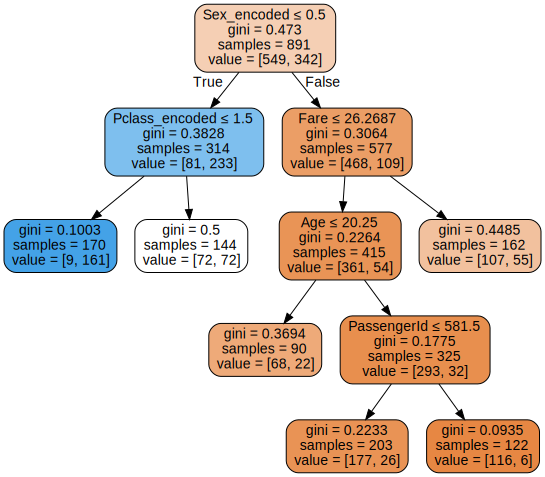

In [24]:
import graphviz 

dot_data = tree.export_graphviz(clf, 
                                out_file=None,
                                filled=True, 
                                rounded=True,  
                                special_characters=True,
                               feature_names = train_columns) 
graph = graphviz.Source(dot_data)
graph

## Prediction on the test set

In [25]:
prediction_values = clf.predict(tree_data["test"]).astype(int)
prediction = pd.DataFrame({"PassengerId":tree_data["test"]["PassengerId"],
                           "Survived":prediction_values})

prediction
prediction.to_csv("Titanic_tree_prediction.csv",index=False)

## 5. Evaluation

## 6. Conclusion